# **Image Reconstruction**

In [1]:
# Own modules
from src.utils import show_image, seed_all, MAE, save_model, load_model
from src.data_processing import download_dataset, get_dataset
from src.models import ColorizationNet
from src.train import train
from src.evaluate import validate
from src.predict import predict_image


# Other libraries
import warnings
import os
import torch

# Paths
IMAGES_PATH = "images/"
DATA_PATH = "data/"
MODELS_PATH = "models/"

# seed
seed = 42
seed_all(seed)

In [2]:
# CONSTANTS
DATASET_ID = ("testdummyvt/cocohumanparts", "COCO_humanparts")
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
HYPERPARAMETERS = {
    "size": (512, 512),  # Image size
    "batch_size": 16,
    "learning_rate": 0.001,
    "num_epochs": 4,
    "num_layers": 5,
    "base_filters": 32,
    "num_workers": 4,
    "activation": "leakyrelu",
    "dropout": 0.5,
    "optimizer": "adam",
    "loss_function": MAE,
    "scheduler": torch.optim.lr_scheduler.StepLR,
    "scheduler_step_size": 1,
    "scheduler_gamma": 0.1,
    "conv_params": [
    {"kernel": 7, "stride": 2, "padding": 3},  # 512 → 256
    {"kernel": 3, "stride": 2, "padding": 1},  # 256 → 128
    {"kernel": 3, "stride": 2, "padding": 1},  # 128 → 64
    {"kernel": 3, "stride": 2, "padding": 1},  # 64 → 32
    {"kernel": 3, "stride": 2, "padding": 1},  # 32 → 16
]


}

**Loading the data**

In [4]:
train_dataset, val_dataset = get_dataset(DATA_PATH, HYPERPARAMETERS["size"], 0.1)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
train_dataset.image_paths

Train dataset size: 27453
Validation dataset size: 3051


['data/train/100006.jpg',
 'data/train/100010.jpg',
 'data/train/100016.jpg',
 'data/train/100021.jpg',
 'data/train/10008.jpg',
 'data/train/100090.jpg',
 'data/train/100111.jpg',
 'data/train/100132.jpg',
 'data/train/100166.jpg',
 'data/train/100199.jpg',
 'data/train/100203.jpg',
 'data/train/100215.jpg',
 'data/train/10023.jpg',
 'data/train/100231.jpg',
 'data/train/100234.jpg',
 'data/train/100238.jpg',
 'data/train/100245.jpg',
 'data/train/100274.jpg',
 'data/train/100283.jpg',
 'data/train/100329.jpg',
 'data/train/100344.jpg',
 'data/train/100354.jpg',
 'data/train/10039.jpg',
 'data/train/10040.jpg',
 'data/train/100404.jpg',
 'data/train/100409.jpg',
 'data/train/100428.jpg',
 'data/train/100430.jpg',
 'data/train/100434.jpg',
 'data/train/100489.jpg',
 'data/train/100539.jpg',
 'data/train/100543.jpg',
 'data/train/100547.jpg',
 'data/train/100553.jpg',
 'data/train/10056.jpg',
 'data/train/100604.jpg',
 'data/train/100678.jpg',
 'data/train/100711.jpg',
 'data/train/1007

In [5]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=HYPERPARAMETERS["batch_size"],
    shuffle=True,
    num_workers=HYPERPARAMETERS["num_workers"],
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=HYPERPARAMETERS["batch_size"],
    shuffle=False,
    num_workers=HYPERPARAMETERS["num_workers"],
)


**Train the model**

In [6]:
model = ColorizationNet(
    num_layers=HYPERPARAMETERS["num_layers"],
    activation=HYPERPARAMETERS["activation"],
    dropout=HYPERPARAMETERS["dropout"],
    base_filters=HYPERPARAMETERS["base_filters"],
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=HYPERPARAMETERS["learning_rate"],
)
scheduler = HYPERPARAMETERS["scheduler"](
    optimizer,
    step_size=HYPERPARAMETERS["scheduler_step_size"],
    gamma=HYPERPARAMETERS["scheduler_gamma"],
)

criterion = HYPERPARAMETERS["loss_function"]


In [7]:
model, train_hist, val_hist = train(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=HYPERPARAMETERS["num_epochs"],
    scheduler=scheduler,
    device=device,
)



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 1/4 completed in 480.13s
  Train Loss: 0.0976
  Validation Loss: 0.0611



Epoch 2/4 completed in 479.81s
  Train Loss: 0.0776
  Validation Loss: 0.0609



Epoch 3/4 completed in 480.64s
  Train Loss: 0.0766
  Validation Loss: 0.0615



Epoch 4/4 completed in 480.73s
  Train Loss: 0.0758
  Validation Loss: 0.0617


In [8]:
# Save the model
save_model(model, MODELS_PATH, "colorization_model_deep")

Model saved at models//colorization_model_deep.pth


In [9]:
# Load the model
model2 = ColorizationNet(
    num_layers=HYPERPARAMETERS["num_layers"],
    activation=HYPERPARAMETERS["activation"],
    dropout=HYPERPARAMETERS["dropout"],
    base_filters=HYPERPARAMETERS["base_filters"],
).to(device)

model = load_model(model2, MODELS_PATH, "colorization_model_deep")



**Prediction**

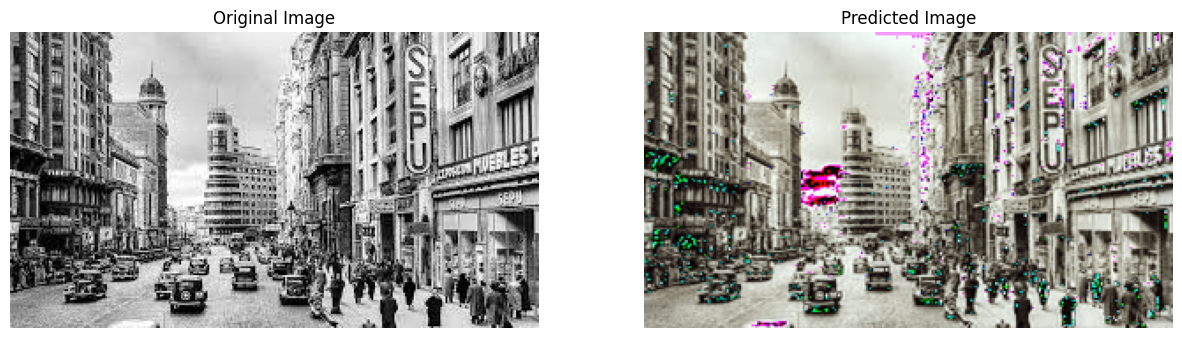

In [10]:
test_image = "data/test/old_madrid.jpeg"

original_image, pred = predict_image(
    model=model2,
    image=test_image,
    device=device,
    size=HYPERPARAMETERS["size"],
)

show_image(original_image, pred)


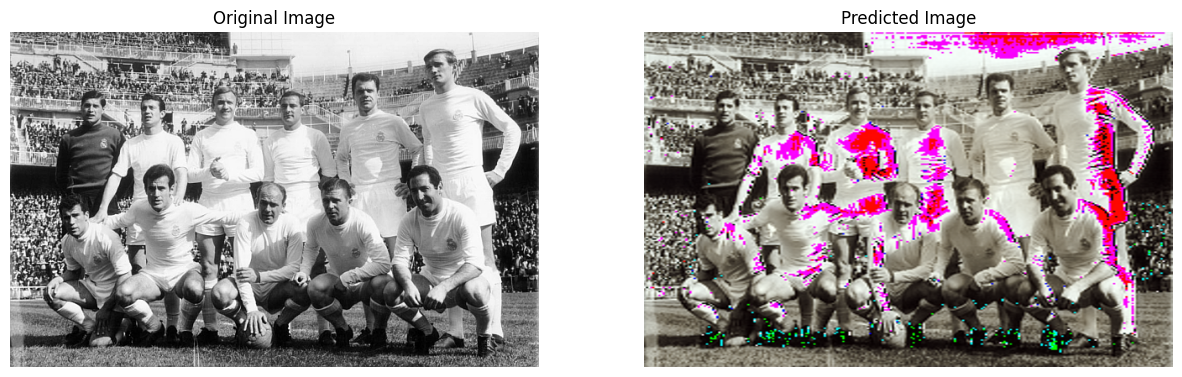

In [13]:
test_image = "data/test/real_madrid.jpg"

original_image, pred = predict_image(
    model=model2,
    image=test_image,
    device=device,
    size=HYPERPARAMETERS["size"],
)

show_image(original_image, pred)

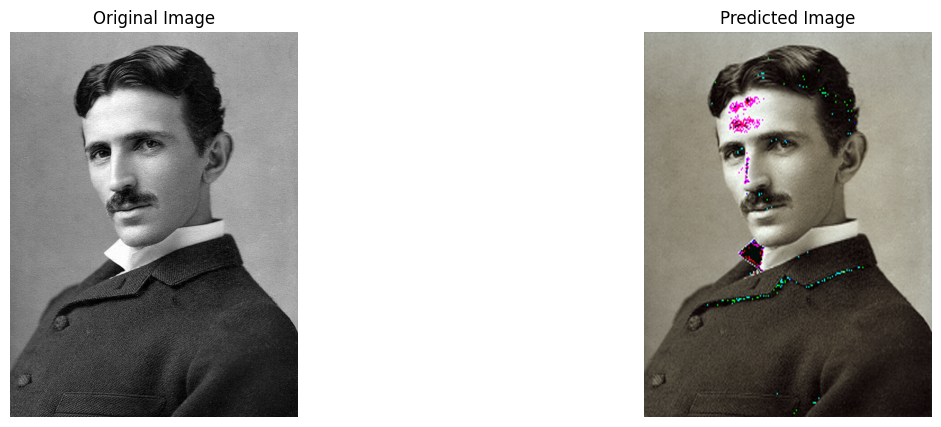

In [14]:
test_image = "data/test/tesla.jpeg"

original_image, pred = predict_image(
    model=model2,
    image=test_image,
    device=device,
    size=HYPERPARAMETERS["size"],
)

show_image(original_image, pred)

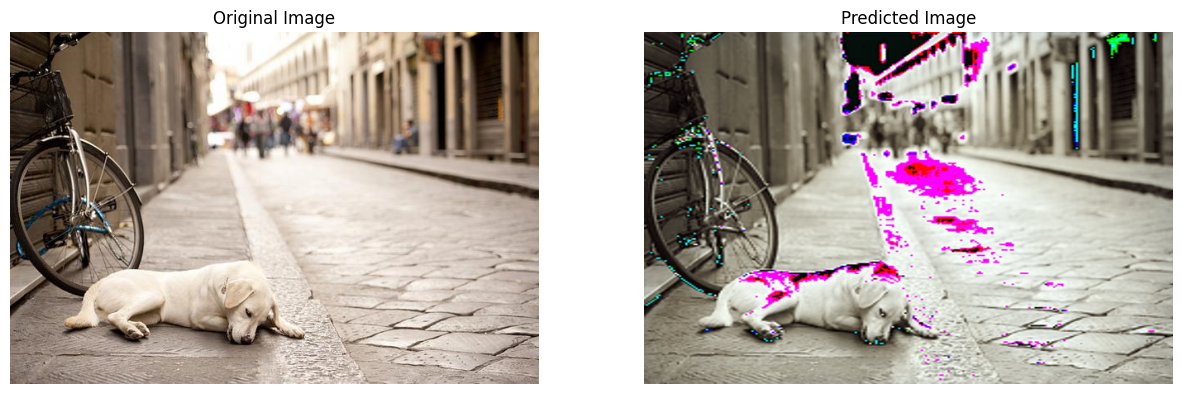

In [15]:
test_image = "data/test/dog.jpg"

original_image, pred = predict_image(
    model=model2,
    image=test_image,
    device=device,
    size=HYPERPARAMETERS["size"],
)

show_image(original_image, pred)